# Import Library

In [32]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
%cd /content/drive/MyDrive/TFT Model

/content/drive/MyDrive/TFT Model


In [34]:
# Install darts library
!pip install -q darts

In [35]:
# Standard Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import ParameterGrid

# Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel

#warning
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("darts").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
# Silence PyTorch Lightning logs
pl_logger = logging.getLogger("pytorch_lightning")
pl_logger.setLevel(logging.WARNING)

In [36]:
df_raw = pd.read_csv('USDJPY_2025.csv')
df = df_raw.copy()
# Gabungkan Date dan Time jadi datetime index
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],format='%m/%d/%Y %I:%M:%S %p')
df.set_index('Datetime', inplace=True)
df = df[['Open', 'High', 'Low', 'Close', 'Tickvol', 'Spread']].copy()  # Keep only relevant columns

# Moving Average (MA20)
df['MA20'] = df['Close'].rolling(window=20).mean()

# Average True Range (ATR)
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['ATR'] = true_range.rolling(window=14).mean()

# RSI (Relative Strength Index)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Stochastic Oscillator (fast %K and slow %D)
low14 = df['Low'].rolling(window=14).min()
high14 = df['High'].rolling(window=14).max()
df['%K'] = 100 * ((df['Close'] - low14) / (high14 - low14))
df['%D'] = df['%K'].rolling(window=3).mean()

# Supertrend calculation
def calculate_supertrend(df, period=10, multiplier=3):
    hl2 = (df['High'] + df['Low']) / 2
    atr = df['ATR']
    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)

    supertrend = [True] * len(df)

    for i in range(1, len(df)):
        if df['Close'].iloc[i] > upperband.iloc[i - 1]:
            supertrend[i] = True
        elif df['Close'].iloc[i] < lowerband.iloc[i - 1]:
            supertrend[i] = False
        else:
            supertrend[i] = supertrend[i - 1]
            if supertrend[i] and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if not supertrend[i] and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

    df['Supertrend'] = supertrend
    return df

df = calculate_supertrend(df)

#future covariate

# Pastikan index datetime
df.index = pd.to_datetime(df.index)

def generate_nfp_hours_mt_timezone(start_year, end_year):
    nfp_hours = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            first_day = pd.Timestamp(f"{year}-{month:02d}-01")
            for i in range(7):
                day = first_day + pd.Timedelta(days=i)
                if day.weekday() == 4:  # Friday
                    # Round to 15:00 to match MetaTrader candle
                    nfp_hour = pd.Timestamp(f"{day.date()} 15:00:00")
                    nfp_hours.append(nfp_hour)
                    break
    return pd.Series(nfp_hours)

# missing value
df.index = pd.to_datetime(df.index)
df = df.asfreq("h")  # Set agar frekuensi waktu hourly dan konsisten

# Tangani missing value (jika ada)
df = df.fillna(method="ffill")  # atau bisa diinterpolasi
# Sesuaikan rentang tahun sesuai data kamu
nfp_hours_mt = generate_nfp_hours_mt_timezone(2024, 2025)
df['is_nfp'] = df.index.floor("H").isin(nfp_hours_mt).astype(int)

df['Supertrend'] = df['Supertrend'].astype(int)
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['is_market_open'] = (df['weekday'] < 5).astype(int)  # Monday–Friday only as in forex market only open thoes day

# Tampilkan beberapa baris pertama hasilnya
print(df[['Close', 'MA20', 'ATR', 'RSI', '%K', '%D', 'Supertrend']].head(25))

df.tail()

                       Close  MA20  ATR  RSI  %K  %D  Supertrend
Datetime                                                        
2025-01-01 00:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 01:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 02:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 03:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 04:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 05:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 06:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 07:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 08:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 09:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 10:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 11:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 12:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 13:00:00  157.

Open     High      Low    Close  Tickvol  Spread  \
Datetime                                                                   
2025-06-03 19:00:00  143.931  144.101  143.869  143.971   3522.0    13.0   
2025-06-03 20:00:00  143.970  144.021  143.830  143.838   2825.0    13.0   
2025-06-03 21:00:00  143.840  143.935  143.830  143.899   2617.0    13.0   
2025-06-03 22:00:00  143.899  144.098  143.889  144.064   2491.0    13.0   
2025-06-03 23:00:00  144.063  144.068  143.887  143.896   1264.0    13.0   

                          MA20       ATR        RSI         %K         %D  \
Datetime                                                                    
2025-06-03 19:00:00  143.07985  0.268429  77.267081  91.339107  91.694321   
2025-06-03 20:00:00  143.13925  0.264357  70.385757  82.478348  90.042384   
2025-06-03 21:00:00  143.20805  0.249857  81.396867  86.542305  86.786587   
2025-06-03 22:00:00  143.29035  0.246714  83.146067  97.534977  88.851877   
2025-06-03 23:00:00  143.35015  0.242000  78.416062  86.342438  90.139907   

                     Supertrend  is_nfp  hour  weekday  is_market_open  
Datetime                                                                
2025-06-03 19:00:00           1       0    19        1               1  
2025-06-03 20:00:00           1       0    20        1               1  
2025-06-03 21:00:00           1       0    21        1               1  
2025-06-03 22:00:00           1       0    22        1               1  
2025-06-03 23:00:00           1       0    23        1               1

In [37]:
print(df.index.freq)

<Hour>


In [38]:
df.isnull().sum()

Open               0
High               0
Low                0
Close              0
Tickvol            0
Spread             0
MA20              42
ATR               36
RSI               36
%K                36
%D                38
Supertrend         0
is_nfp             0
hour               0
weekday            0
is_market_open     0
dtype: int64

In [39]:
df = df.dropna().copy()
df

Open     High      Low    Close  Tickvol  Spread  \
Datetime                                                                   
2025-01-02 18:00:00  157.147  157.749  157.131  157.659   3816.0     4.0   
2025-01-02 19:00:00  157.659  157.848  157.489  157.564   3535.0     4.0   
2025-01-02 20:00:00  157.563  157.630  157.464  157.499   2955.0     4.0   
2025-01-02 21:00:00  157.498  157.671  157.475  157.618   2471.0     3.0   
2025-01-02 22:00:00  157.617  157.654  157.566  157.627   2182.0     4.0   
...                      ...      ...      ...      ...      ...     ...   
2025-06-03 19:00:00  143.931  144.101  143.869  143.971   3522.0    13.0   
2025-06-03 20:00:00  143.970  144.021  143.830  143.838   2825.0    13.0   
2025-06-03 21:00:00  143.840  143.935  143.830  143.899   2617.0    13.0   
2025-06-03 22:00:00  143.899  144.098  143.889  144.064   2491.0    13.0   
2025-06-03 23:00:00  144.063  144.068  143.887  143.896   1264.0    13.0   

                          MA20       ATR        RSI         %K         %D  \
Datetime                                                                    
2025-01-02 18:00:00  157.12990  0.340500  56.850566  93.124523  69.021106   
2025-01-02 19:00:00  157.15505  0.354000  57.480606  79.829545  79.728063   
2025-01-02 20:00:00  157.16710  0.354286  59.073652  75.213068  82.722379   
2025-01-02 21:00:00  157.16310  0.351857  58.021807  83.664773  79.569129   
2025-01-02 22:00:00  157.17290  0.318786  73.806007  84.303977  81.060606   
...                        ...       ...        ...        ...        ...   
2025-06-03 19:00:00  143.07985  0.268429  77.267081  91.339107  91.694321   
2025-06-03 20:00:00  143.13925  0.264357  70.385757  82.478348  90.042384   
2025-06-03 21:00:00  143.20805  0.249857  81.396867  86.542305  86.786587   
2025-06-03 22:00:00  143.29035  0.246714  83.146067  97.534977  88.851877   
2025-06-03 23:00:00  143.35015  0.242000  78.416062  86.342438  90.139907   

                     Supertrend  is_nfp  hour  weekday  is_market_open  
Datetime                                                                
2025-01-02 18:00:00           1       0    18        3               1  
2025-01-02 19:00:00           1       0    19        3               1  
2025-01-02 20:00:00           1       0    20        3               1  
2025-01-02 21:00:00           1       0    21        3               1  
2025-01-02 22:00:00           1       0    22        3               1  
...                         ...     ...   ...      ...             ...  
2025-06-03 19:00:00           1       0    19        1               1  
2025-06-03 20:00:00           1       0    20        1               1  
2025-06-03 21:00:00           1       0    21        1               1  
2025-06-03 22:00:00           1       0    22        1               1  
2025-06-03 23:00:00           1       0    23        1               1  

[3654 rows x 16 columns]

In [40]:
# Show Non-Farm Payroll (NFP) date release
df[df['is_nfp'] == 1]

Open     High      Low    Close  Tickvol  Spread  \
Datetime                                                                   
2025-01-03 15:00:00  157.162  157.239  157.023  157.185   2839.0     4.0   
2025-02-07 15:00:00  152.008  152.413  151.297  151.953   4510.0     3.0   
2025-03-07 15:00:00  147.734  147.966  147.115  147.225   5298.0     3.0   
2025-04-04 15:00:00  145.371  145.637  145.017  145.594  10962.0    13.0   
2025-05-02 15:00:00  144.550  144.952  144.330  144.633   7799.0    13.0   

                          MA20       ATR        RSI         %K         %D  \
Datetime                                                                    
2025-01-03 15:00:00  157.32675  0.201071  42.265193  37.241379  33.151707   
2025-02-07 15:00:00  151.65430  0.303786  77.896233  68.363136  82.484912   
2025-03-07 15:00:00  147.68345  0.349357  29.912664  10.536398  39.631952   
2025-04-04 15:00:00  145.93650  0.570500  49.659266  52.731830  33.469592   
2025-05-02 15:00:00  145.20660  0.347500  36.178700  19.165085  15.634407   

                     Supertrend  is_nfp  hour  weekday  is_market_open  
Datetime                                                                
2025-01-03 15:00:00           1       1    15        4               1  
2025-02-07 15:00:00           1       1    15        4               1  
2025-03-07 15:00:00           0       1    15        4               1  
2025-04-04 15:00:00           0       1    15        4               1  
2025-05-02 15:00:00           0       1    15        4               1

In [41]:
# Information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2025-01-02 18:00:00 to 2025-06-03 23:00:00
Freq: h
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            3654 non-null   float64
 1   High            3654 non-null   float64
 2   Low             3654 non-null   float64
 3   Close           3654 non-null   float64
 4   Tickvol         3654 non-null   float64
 5   Spread          3654 non-null   float64
 6   MA20            3654 non-null   float64
 7   ATR             3654 non-null   float64
 8   RSI             3654 non-null   float64
 9   %K              3654 non-null   float64
 10  %D              3654 non-null   float64
 11  Supertrend      3654 non-null   int64  
 12  is_nfp          3654 non-null   int64  
 13  hour            3654 non-null   int32  
 14  weekday         3654 non-null   int32  
 15  is_market_open  3654 non-null   int64  
dtypes: float64(11), int32(2), int64(3)

In [42]:
df.isnull().sum()

Open              0
High              0
Low               0
Close             0
Tickvol           0
Spread            0
MA20              0
ATR               0
RSI               0
%K                0
%D                0
Supertrend        0
is_nfp            0
hour              0
weekday           0
is_market_open    0
dtype: int64

# Time series Object

In [81]:
# === BUILD TIMESERIES OBJECTS ===
series = TimeSeries.from_dataframe(df, value_cols="Close")
past_cov = TimeSeries.from_dataframe(df.iloc[:, 4:12])
future_cov = TimeSeries.from_dataframe(df.iloc[:, 12:])

In [82]:
# === SCALE ===
scaler1 = Scaler()
scaler2 = Scaler()
series_scaled = scaler1.fit_transform(series)
past_cov_scaled = scaler2.fit_transform(past_cov)
future_cov_scaled = scaler2.fit_transform(future_cov)

In [83]:
# === TRAIN/TEST SPLIT ===
n = 24
train, val = series_scaled[:-n], series_scaled[-n:]
train_pc, val_pc = past_cov_scaled[:-n], past_cov_scaled[-n:]
train_fc, val_fc = future_cov_scaled[:-n], future_cov_scaled[-n:]


# Predict The Future

In [84]:
params = pd.read_csv('best_params.csv', index_col=0).drop(columns='rmse').squeeze().to_dict()
for k in ['input_chunk_length', 'output_chunk_length', 'hidden_size', 'num_attention_heads',
          'batch_size', 'lstm_layers', 'n_epochs']:
    params[k] = int(params[k])

In [87]:
def encode_year(idx):
    return (idx.year - 2000) / 50

params.update({
    'use_static_covariates': True,
    'add_encoders': {
        'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
        'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
        'position': {'past': ['relative'], 'future': ['relative']},
        'custom': {'past': [encode_year], 'future': [encode_year]},
        'transformer': Scaler(),
        'tz': 'Etc/GMT-2'
    },
    'pl_trainer_kwargs': {'accelerator': 'cpu'}
})


In [89]:
input_chunk = model.input_chunk_length
val_pc = past_cov_scaled[-(n + input_chunk):]
val_fc = future_cov_scaled[-(n + input_chunk):]


In [90]:
# === TRAIN & FORECAST ===
model = TFTModel(**params)
model.fit(train, past_covariates=train_pc, future_covariates=train_fc)

forecast = model.predict(n=n, past_covariates=val_pc, future_covariates=val_fc)
forecast_df = scaler1.inverse_transform(forecast).to_dataframe()
forecast_df.columns = ["TFT"]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

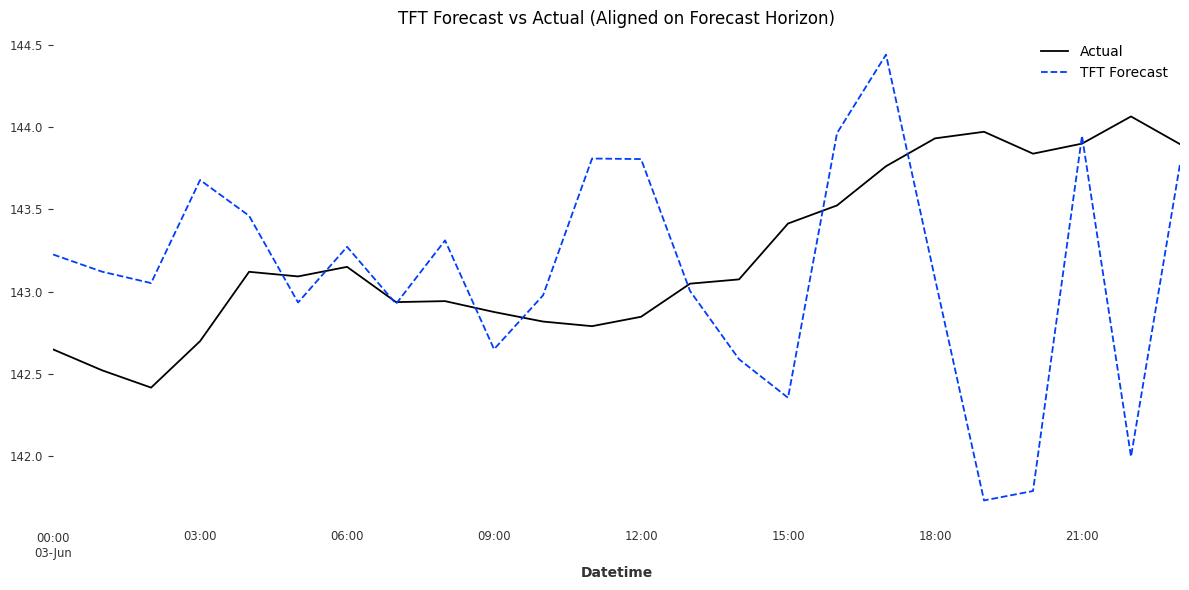

In [109]:
# Step 1: Extract forecast time index
forecast_index = forecast_df.index

# Step 2: Align actuals on the same forecast period
actual_forecast_period = actual_df.loc[forecast_index]

# Step 3: Plot only forecast horizon
plt.figure(figsize=(12, 6))
actual_forecast_period["Actual"].plot(label="Actual")
forecast_df["TFT"].plot(label="TFT Forecast", linestyle="--")

plt.title("TFT Forecast vs Actual")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [131]:
y_true = actual_forecast_period["Actual"].values
y_pred = forecast_df["TFT"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape*100:.2f}%")


MAE: 0.6758
RMSE: 0.8576
MAPE: 0.47%


# Interpretability

In [126]:
output_chunk = tuned_model.output_chunk_length
last_time = train_fc.end_time()
new_times = pd.date_range(start=last_time + pd.Timedelta(hours=1), periods=output_chunk, freq="H")

hour_series = datetime_attribute_timeseries(new_times, attribute="hour", dtype=float)\
    .with_columns_renamed(["hour"], ["hour"])

weekday_series = datetime_attribute_timeseries(new_times, attribute="day_of_week", dtype=float)\
    .with_columns_renamed(["day_of_week"], ["weekday"])

is_market_open = [1.0 if ts.weekday() < 5 else 0.0 for ts in new_times]
is_nfp = [1.0 if ts.weekday() == 4 and 1 <= ts.day <= 7 and ts.hour == 15 else 0.0 for ts in new_times]

is_market_open_ts = TimeSeries.from_times_and_values(new_times, np.array(is_market_open).reshape(-1, 1)).with_columns_renamed(["0"], ["is_market_open"])
is_nfp_ts = TimeSeries.from_times_and_values(new_times, np.array(is_nfp).reshape(-1, 1)).with_columns_renamed(["0"], ["is_nfp"])
extended_part = hour_series.stack(weekday_series).stack(is_market_open_ts).stack(is_nfp_ts)
extended_part_scaled = scaler2.transform(extended_part)
train_fc_extended = train_fc.append(extended_part_scaled)


In [127]:
explainability_result = explainer.explain(train, train_pc, train_fc_extended)


Predicting: |          | 0/? [00:00<?, ?it/s]

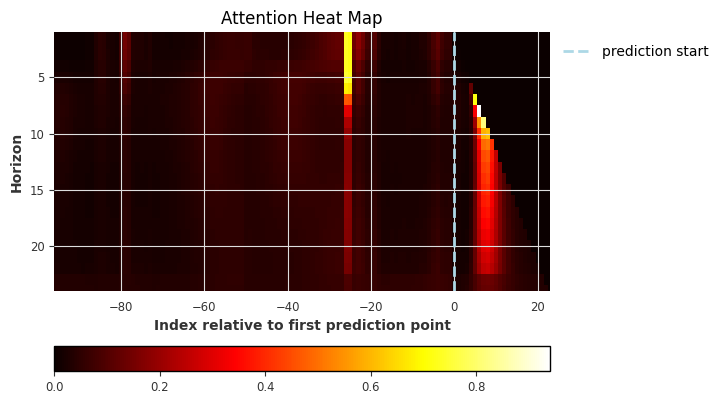

<Axes: title={'center': 'Attention Heat Map'}, xlabel='Index relative to first prediction point', ylabel='Horizon'>

In [128]:
# Plot the attention mechanism for the model
explainer.plot_attention(explainability_result, plot_type = "heatmap")

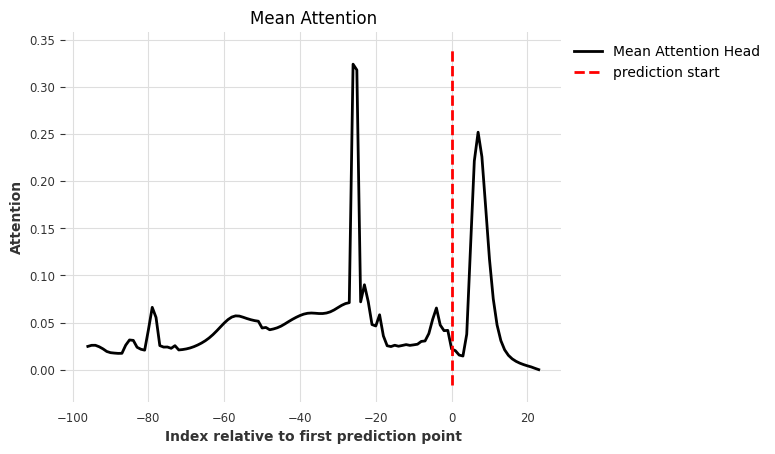

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [129]:
# Plot the attention mechanism for the model
explainer.plot_attention(explainability_result, plot_type = "time")